In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Rectangle

import os

In [9]:
with open("significance_pickles/033BasicPlans.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
def moving_average(data, window=3):
    """Apply a moving average to the data."""
    if len(data) < window:
        return data
    
    smoothed = []
    for i in range(len(data)):
        if i < window - 1:
            # For the first few points, use available data
            smoothed.append(np.mean(data[:i+1]))
        else:
            # Use the window
            smoothed.append(np.mean(data[i-window+1:i+1]))
    
    return smoothed


In [5]:
def smooth_dict_data(data_dict, window=3):
    """Apply moving average to dictionary data and return smoothed dictionary."""
    if not data_dict:
        return {}
    
    # Extract and sort the data
    x_vals = list(data_dict.keys())
    y_vals = list(data_dict.values())
    
    # Sort by x values
    sorted_pairs = sorted(zip(x_vals, y_vals))
    x_vals, y_vals = zip(*sorted_pairs)
    
    # Apply moving average
    y_vals_smoothed = moving_average(list(y_vals), window=window)
    
    # Return as dictionary
    return dict(zip(x_vals, y_vals_smoothed))

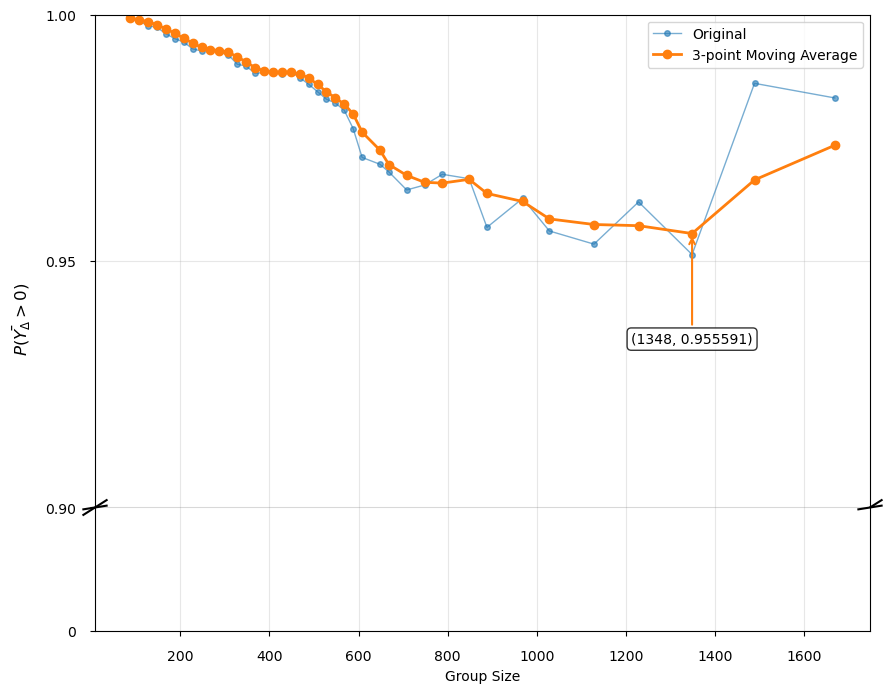

In [45]:
# Load the original data first
with open("significance_pickles/033BasicPlans.pkl", "rb") as f:
    original_data = pickle.load(f)

# Apply smoothing
smoothed_data = smooth_dict_data(original_data)

# Find the minimum point in the smoothed data
min_x = min(smoothed_data, key=smoothed_data.get)
min_y = smoothed_data[min_x]

# Calculate the proportional heights based on y-axis ranges
upper_range = 1.0 - 0.9  # 0.1
lower_range = 0.025 - 0.0  # 0.025
total_range = upper_range + lower_range  # 0.125

# Set height ratios proportional to the actual data ranges
height_ratios = [upper_range/total_range, lower_range/total_range]  # [0.8, 0.2]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), 
                               gridspec_kw={'height_ratios': height_ratios, 'hspace': 0})

# Plot the upper part (0.9 to 1.0)
ax1.plot(original_data.keys(), original_data.values(), 'o-', linewidth=1, markersize=4, alpha=0.6, label='Original')
line1 = ax1.plot(smoothed_data.keys(), smoothed_data.values(), 'o-', linewidth=2, markersize=6, label='3-point Moving Average')
ax1.set_ylim(0.9, 1.0)
ax1.set_yticks([0.9, 0.95, 1.0])
ax1.grid(True, alpha=0.3)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False, left=True, pad=10)
ax1.legend()

# Plot the lower part (0 to 0.025)
ax2.plot(original_data.keys(), original_data.values(), 'o-', linewidth=1, markersize=4, alpha=0.6)
line2 = ax2.plot(smoothed_data.keys(), smoothed_data.values(), 'o-', linewidth=2, markersize=6)

# Get the color of the moving average line
ma_color = line1[0].get_color()

# Add annotation with arrow pointing to the minimum point (using same color as MA line)
if min_y >= 0.9:
    ax1.annotate(f'({min_x}, {min_y:.6f})', 
                xy=(min_x, min_y), 
                xytext=(min_x, min_y - 0.02),
                arrowprops=dict(arrowstyle='->', color=ma_color, lw=1.5),
                fontsize=10, ha='center', va='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
else:
    ax2.annotate(f'({min_x}, {min_y:.6f})', 
                xy=(min_x, min_y), 
                xytext=(min_x, min_y - 0.005),
                arrowprops=dict(arrowstyle='->', color=ma_color, lw=1.5),
                fontsize=10, ha='center', va='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax2.set_ylim(0, 0.025)
ax2.set_yticks([0.00])
ax2.set_xlabel('Group Size')
ax2.grid(True, alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.tick_params(left=True, pad=10)

# Add horizontal grid line at y=0.025 on the lower plot to show the break point
ax2.axhline(y=0.025, color='gray', alpha=0.3, linewidth=0.8)  # Grid line at break point

# Add break symbols on the y-axis
d = 0.015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)      # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)      # bottom-left diagonal
ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)    # bottom-right diagonal

# Add single y-axis label centered between both subplots
fig.text(0.04, 0.5, r'$P(\bar{Y_{\Delta}} > 0)$', fontsize=12, va='center', rotation=90)

plt.show()

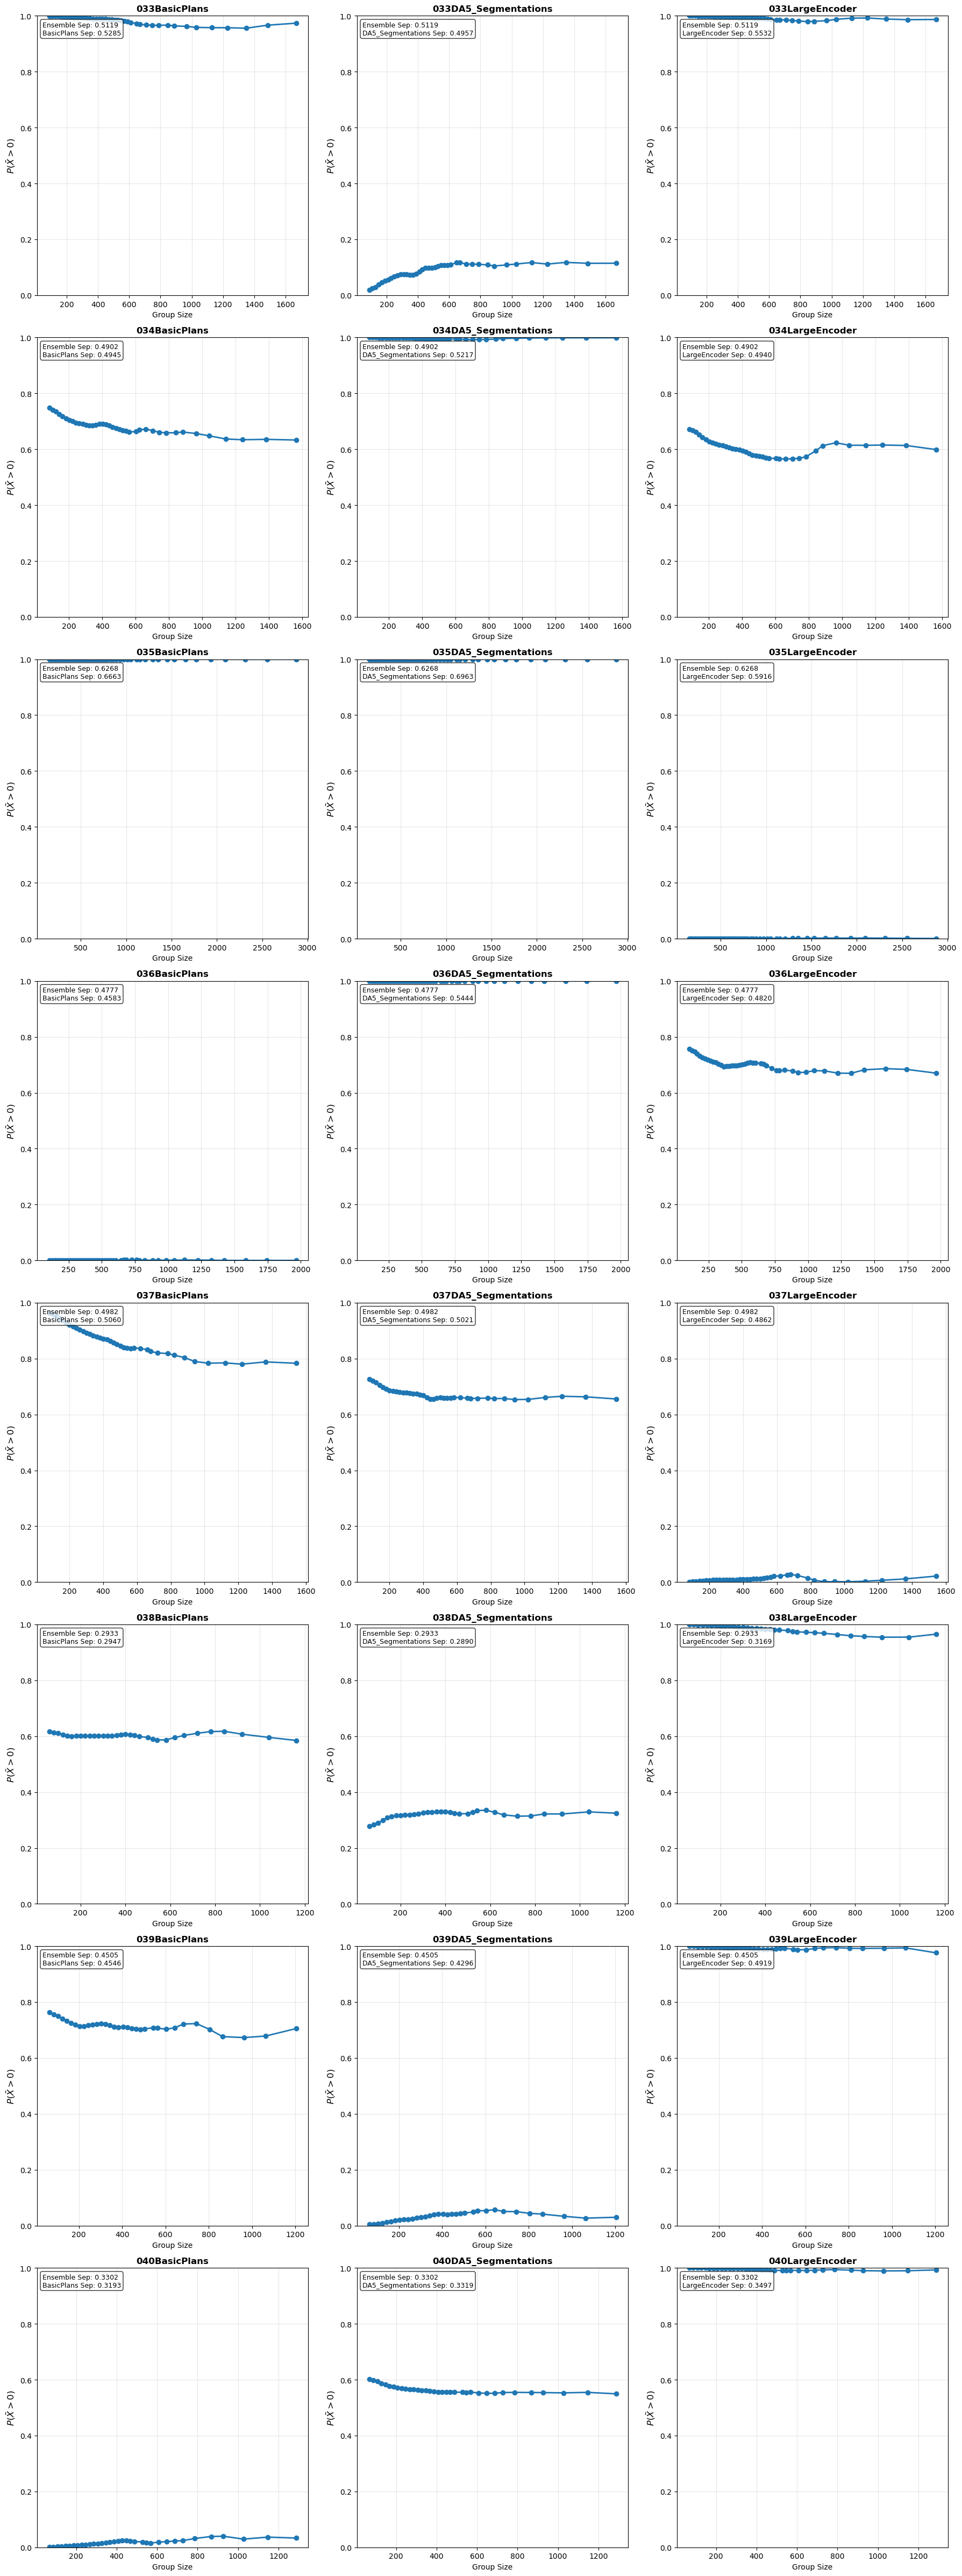


Comparison Summary (Ensemble vs Models):
Image 033 vs BasicPlans:
  Ensemble Separation Distance: 0.5119 | BasicPlans Separation Distance: 0.5285


KeyError: 'significance'

In [49]:
import re
import numpy as np

def parse_performance_file(filename="performance_print.txt"):
    """Parse performance data directly from the text file."""
    performance_data = {}
    
    with open(filename, 'r') as f:
        content = f.read()
    
    # Find the pivot table section
    pivot_start = content.find("Pivot Table (Training Images vs Models):")
    if pivot_start == -1:
        print("Pivot table not found!")
        return {}
    
    # Extract the pivot table section
    pivot_section = content[pivot_start:]
    lines = pivot_section.split('\n')
    
    # Find the header line with model names
    header_line = None
    for i, line in enumerate(lines):
        if 'BasicPlans' in line and 'DA5_Segmentations' in line:
            header_line = line
            data_start_idx = i + 1
            break
    
    if header_line is None:
        print("Header line not found!")
        return {}
    
    # Parse model names from header
    header_clean = re.sub(r'Model\s+', '', header_line)
    models = re.split(r'\s{2,}', header_clean.strip())
    
    # Initialize performance_data structure
    for model in models:
        performance_data[model] = {}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        line = line.strip()
        if not line or not line[0].isdigit():
            continue
            
        parts = line.split()
        if len(parts) != len(models) + 1:
            continue
            
        image_num = parts[0]
        values = parts[1:]
        
        for model, value in zip(models, values):
            try:
                performance_data[model][image_num] = float(value)
            except ValueError:
                continue
    
    return performance_data

def parse_filename(filename):
    """Extract image number and model name from filename like '033BasicPlans'"""
    for i, char in enumerate(filename):
        if not char.isdigit():
            image_num = filename[:i]
            model_name = filename[i:]
            return image_num, model_name
    return None, None


# Parse the performance data
performance_data = parse_performance_file("performance_print.txt")

# Load pickle data
pickle_dir = "significance_pickles"
if os.path.exists(pickle_dir):
    all_files = os.listdir(pickle_dir)
    pickle_files = [f for f in all_files if f.endswith('.pkl')]
    pickle_files = [os.path.join(pickle_dir, f) for f in pickle_files]
else:
    pickle_files = []
    print("significance_pickles directory not found!")

all_data = {}
for file_path in pickle_files:
    filename = os.path.basename(file_path).replace('.pkl', '')
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_data[filename] = data
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

# Dictionary to store minimum p-values
p_vals = {}

# Create enhanced plotting with both ensemble and model separation distances
if all_data:
    # Sort data by image number first, then by model name
    sorted_items = []
    for filename, data in all_data.items():
        image_num, model_name = parse_filename(filename)
        if image_num and model_name:
            sorted_items.append((image_num, model_name, filename, data))
    
    # Sort by image number, then by model name
    sorted_items.sort(key=lambda x: (x[0], x[1]))
    
    n_files = len(sorted_items)
    cols = min(3, n_files)
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
    # Handle different subplot configurations
    if n_files == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each dataset in sorted order
    for i, (image_num, model_name, filename, data) in enumerate(sorted_items):
        if isinstance(data, dict) and data:
            x_vals = list(data.keys())
            y_vals = list(data.values())
            
            # Sort by x values
            sorted_pairs = sorted(zip(x_vals, y_vals))
            x_vals, y_vals = zip(*sorted_pairs)
            
            # Apply 3-term moving average
            y_vals_smoothed = moving_average(list(y_vals), window=3)
            
            # Find minimum point after smoothing for group_size > 600
            filtered_data = [(x, y) for x, y in zip(x_vals, y_vals_smoothed) if x > 600]
            
            if filtered_data:
                min_x, min_y = min(filtered_data, key=lambda x: x[1])
                # Store in p_vals dictionary
                p_vals[filename] = min_y
            else:
                # Fallback to overall minimum if no data > 600
                min_idx = np.argmin(y_vals_smoothed)
                min_x = x_vals[min_idx]
                min_y = y_vals_smoothed[min_idx]
                p_vals[filename] = min_y
            
            axes[i].plot(x_vals, y_vals_smoothed, 'o-', linewidth=2, markersize=6)
            axes[i].set_xlabel('Group Size')
            # Updated y-axis label with mathematical notation
            axes[i].set_ylabel(r'$P(\bar{X} > 0)$', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            
            # Fixed y-axis limits from 0 to 1
            axes[i].set_ylim(0, 1.0)
            
            # Get separation distances for both ensemble and model
            ensemble_sep = None
            model_sep = None
            if 'Ensemble' in performance_data:
                ensemble_sep = performance_data['Ensemble'].get(image_num)
            if model_name in performance_data:
                model_sep = performance_data[model_name].get(image_num)
            
            # Add separation distances as text on the plot
            text_lines = []
            if ensemble_sep is not None:
                text_lines.append(f"Ensemble Sep: {ensemble_sep:.4f}")
            if model_sep is not None:
                text_lines.append(f"{model_name} Sep: {model_sep:.4f}")
            
            if text_lines:
                text_content = '\n'.join(text_lines)
                axes[i].text(0.02, 0.98, text_content, transform=axes[i].transAxes,
                           fontsize=9, verticalalignment='top', horizontalalignment='left',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Simple title with just filename
            axes[i].set_title(filename, fontsize=12, fontweight='bold')
            
        else:
            axes[i].text(0.5, 0.5, f'No data\nin {filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{filename} (No Data)", fontsize=12)
    
    # Hide unused subplots
    for i in range(len(sorted_items), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary sorted by image->model with both separation distances
    print(f"\nComparison Summary (Ensemble vs Models):")
    print("=" * 90)
    
    # Collect and sort results by image, then model
    results = []
    for image_num, model_name, filename, data in sorted_items:
        if isinstance(data, dict) and data:
            min_p = p_vals[filename]  # Use the smoothed min value
            max_p = max(data.values())
            significant = "Yes" if max_p > 0.95 else "No"
            
            ensemble_sep = performance_data.get('Ensemble', {}).get(image_num)
            model_sep = performance_data.get(model_name, {}).get(image_num)
            
            results.append({
                'image': image_num,
                'model': model_name,
                'filename': filename,
                'min_p': min_p,
                'max_p': max_p,
                'significant': significant,
                'ensemble_sep': ensemble_sep,
                'model_sep': model_sep
            })
    
    # Print sorted results with improved formatting
    for result in results:
        ensemble_str = f"{result['ensemble_sep']:.4f}" if result['ensemble_sep'] is not None else "N/A"
        model_str = f"{result['model_sep']:.4f}" if result['model_sep'] is not None else "N/A"
        
        print(f"Image {result['image']} vs {result['model']}:")
        print(f"  Ensemble Separation Distance: {ensemble_str} | {result['model']} Separation Distance: {model_str}")
        print(f"  Min p-value: {result['min_p']:.6f} | Max p-value: {result['max_p']:.6f} | Significant: {result['significance']}")
        print()

else:
    print("No data to plot")

# Print the p_vals dictionary
print("\nMinimum P-values Dictionary:")
print("=" * 40)
for filename, min_p in p_vals.items():
    print(f"'{filename}': {min_p:.6f}")

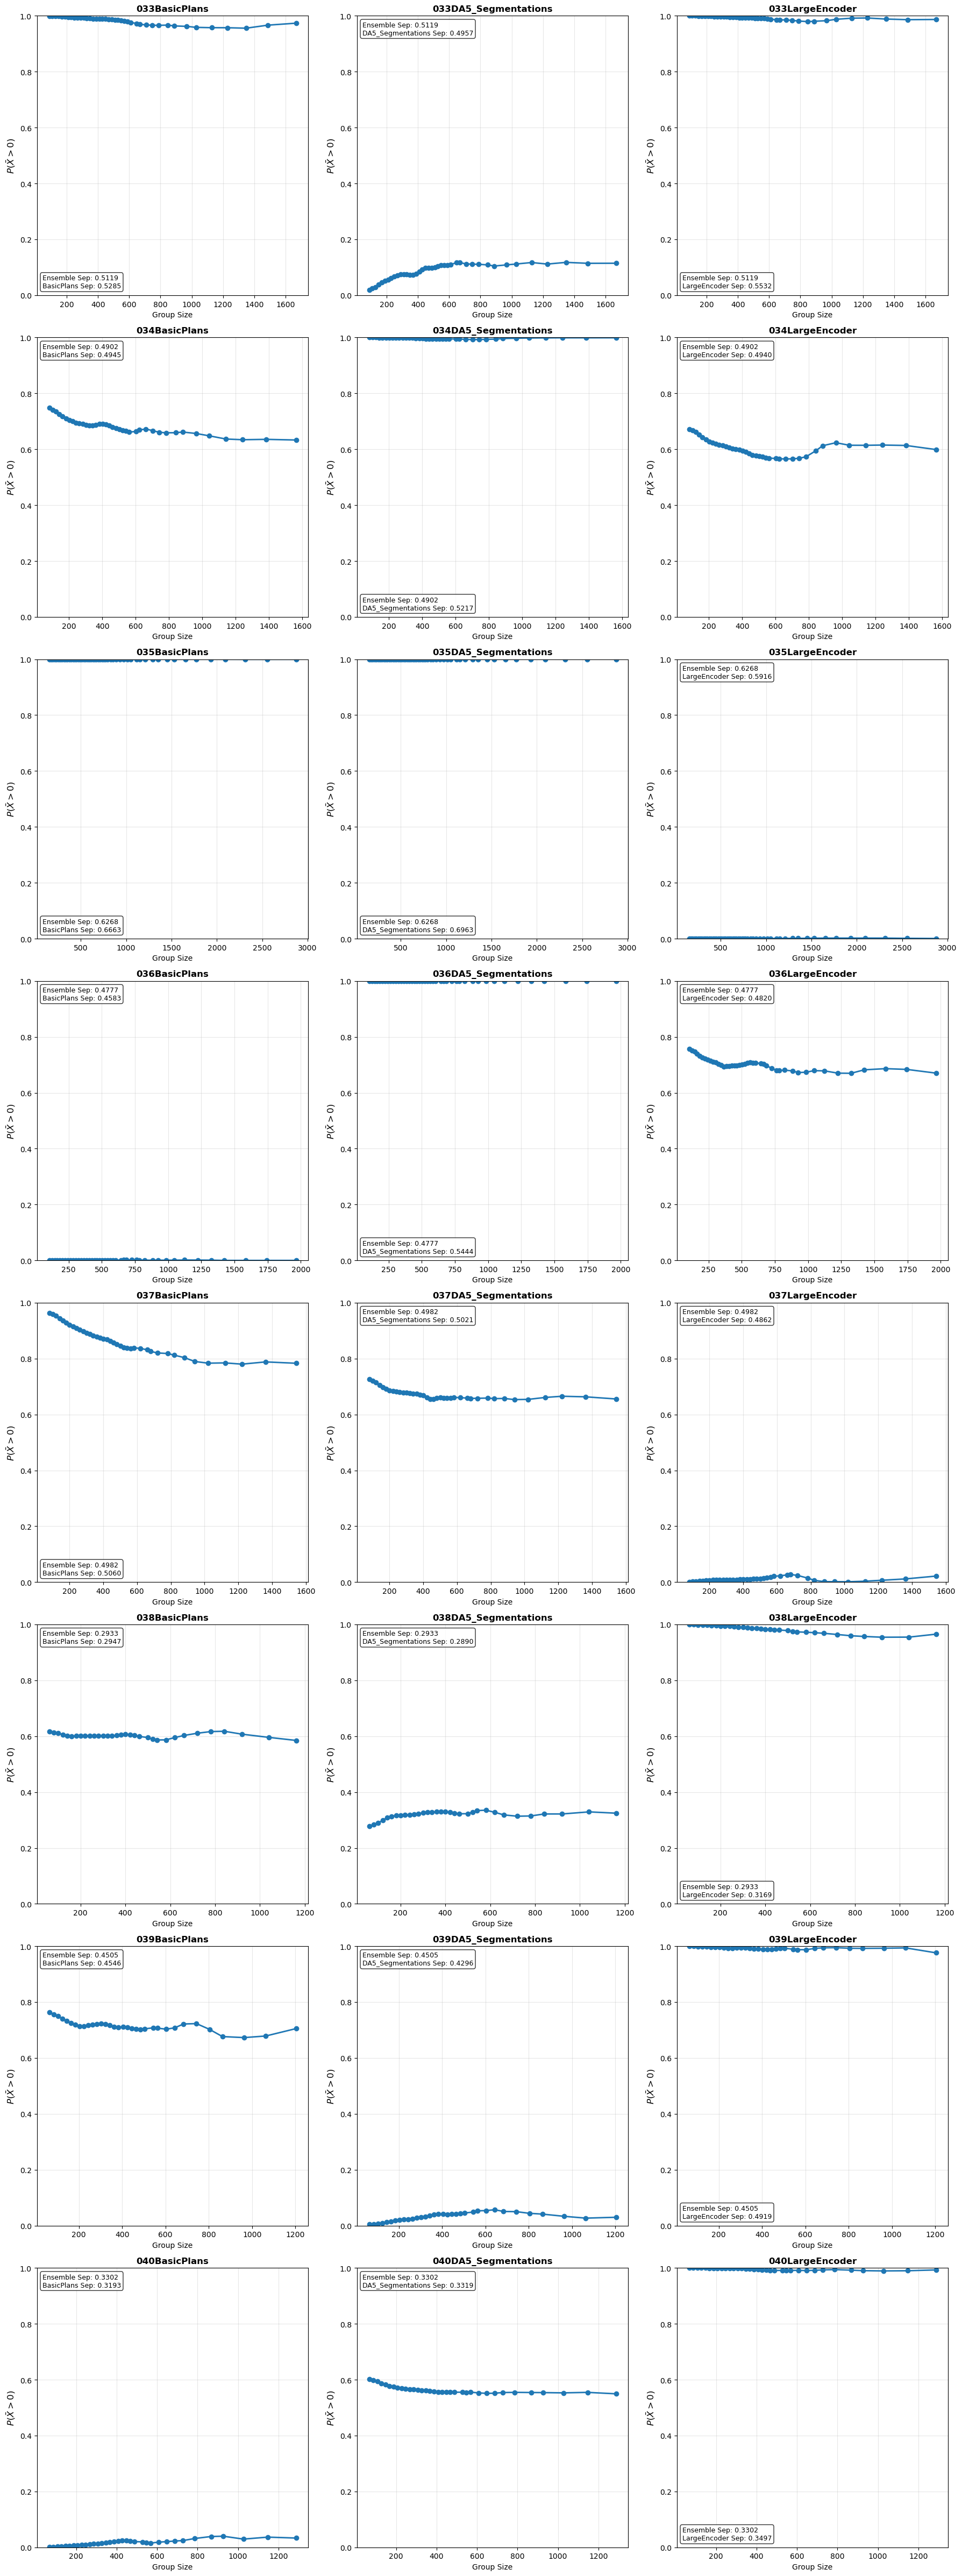


Comparison Summary (Ensemble vs Models):
Image 033 vs BasicPlans:
  Ensemble Separation Distance: 0.5119 | BasicPlans Separation Distance: 0.5285


KeyError: 'significance'

In [50]:
import re
import numpy as np

def parse_performance_file(filename="performance_print.txt"):
    """Parse performance data directly from the text file."""
    performance_data = {}
    
    with open(filename, 'r') as f:
        content = f.read()
    
    # Find the pivot table section
    pivot_start = content.find("Pivot Table (Training Images vs Models):")
    if pivot_start == -1:
        print("Pivot table not found!")
        return {}
    
    # Extract the pivot table section
    pivot_section = content[pivot_start:]
    lines = pivot_section.split('\n')
    
    # Find the header line with model names
    header_line = None
    for i, line in enumerate(lines):
        if 'BasicPlans' in line and 'DA5_Segmentations' in line:
            header_line = line
            data_start_idx = i + 1
            break
    
    if header_line is None:
        print("Header line not found!")
        return {}
    
    # Parse model names from header
    header_clean = re.sub(r'Model\s+', '', header_line)
    models = re.split(r'\s{2,}', header_clean.strip())
    
    # Initialize performance_data structure
    for model in models:
        performance_data[model] = {}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        line = line.strip()
        if not line or not line[0].isdigit():
            continue
            
        parts = line.split()
        if len(parts) != len(models) + 1:
            continue
            
        image_num = parts[0]
        values = parts[1:]
        
        for model, value in zip(models, values):
            try:
                performance_data[model][image_num] = float(value)
            except ValueError:
                continue
    
    return performance_data

def parse_filename(filename):
    """Extract image number and model name from filename like '033BasicPlans'"""
    for i, char in enumerate(filename):
        if not char.isdigit():
            image_num = filename[:i]
            model_name = filename[i:]
            return image_num, model_name
    return None, None


# Parse the performance data
performance_data = parse_performance_file("performance_print.txt")

# Load pickle data
pickle_dir = "significance_pickles"
if os.path.exists(pickle_dir):
    all_files = os.listdir(pickle_dir)
    pickle_files = [f for f in all_files if f.endswith('.pkl')]
    pickle_files = [os.path.join(pickle_dir, f) for f in pickle_files]
else:
    pickle_files = []
    print("significance_pickles directory not found!")

all_data = {}
for file_path in pickle_files:
    filename = os.path.basename(file_path).replace('.pkl', '')
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_data[filename] = data
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

# Dictionary to store minimum p-values
p_vals = {}

# Create enhanced plotting with both ensemble and model separation distances
if all_data:
    # Sort data by image number first, then by model name
    sorted_items = []
    for filename, data in all_data.items():
        image_num, model_name = parse_filename(filename)
        if image_num and model_name:
            sorted_items.append((image_num, model_name, filename, data))
    
    # Sort by image number, then by model name
    sorted_items.sort(key=lambda x: (x[0], x[1]))
    
    n_files = len(sorted_items)
    cols = min(3, n_files)
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
    # Handle different subplot configurations
    if n_files == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each dataset in sorted order
    for i, (image_num, model_name, filename, data) in enumerate(sorted_items):
        if isinstance(data, dict) and data:
            x_vals = list(data.keys())
            y_vals = list(data.values())
            
            # Sort by x values
            sorted_pairs = sorted(zip(x_vals, y_vals))
            x_vals, y_vals = zip(*sorted_pairs)
            
            # Apply 3-term moving average
            y_vals_smoothed = moving_average(list(y_vals), window=3)
            
            # Find minimum point after smoothing for group_size > 600
            filtered_data = [(x, y) for x, y in zip(x_vals, y_vals_smoothed) if x > 600]
            
            if filtered_data:
                min_x, min_y = min(filtered_data, key=lambda x: x[1])
                # Store in p_vals dictionary
                p_vals[filename] = min_y
            else:
                # Fallback to overall minimum if no data > 600
                min_idx = np.argmin(y_vals_smoothed)
                min_x = x_vals[min_idx]
                min_y = y_vals_smoothed[min_idx]
                p_vals[filename] = min_y
            
            axes[i].plot(x_vals, y_vals_smoothed, 'o-', linewidth=2, markersize=6)
            axes[i].set_xlabel('Group Size')
            # Updated y-axis label with mathematical notation
            axes[i].set_ylabel(r'$P(\bar{X} > 0)$', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            
            # Fixed y-axis limits from 0 to 1
            axes[i].set_ylim(0, 1.0)
            
            # Get separation distances for both ensemble and model
            ensemble_sep = None
            model_sep = None
            if 'Ensemble' in performance_data:
                ensemble_sep = performance_data['Ensemble'].get(image_num)
            if model_name in performance_data:
                model_sep = performance_data[model_name].get(image_num)
            
            # Determine optimal text position based on data distribution
            # Check if upper region (0.8-1.0) has fewer data points than lower region (0.0-0.2)
            upper_points = sum(1 for y in y_vals_smoothed if y >= 0.8)
            lower_points = sum(1 for y in y_vals_smoothed if y <= 0.2)
            
            if upper_points <= lower_points:
                # Place in upper region
                text_x, text_y = 0.02, 0.98
                v_align = 'top'
            else:
                # Place in lower region
                text_x, text_y = 0.02, 0.02
                v_align = 'bottom'
            
            # Add separation distances as text on the plot
            text_lines = []
            if ensemble_sep is not None:
                text_lines.append(f"Ensemble Sep: {ensemble_sep:.4f}")
            if model_sep is not None:
                text_lines.append(f"{model_name} Sep: {model_sep:.4f}")
            
            if text_lines:
                text_content = '\n'.join(text_lines)
                axes[i].text(text_x, text_y, text_content, transform=axes[i].transAxes,
                           fontsize=9, verticalalignment=v_align, horizontalalignment='left',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Simple title with just filename
            axes[i].set_title(filename, fontsize=12, fontweight='bold')
            
        else:
            axes[i].text(0.5, 0.5, f'No data\nin {filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{filename} (No Data)", fontsize=12)
    
    # Hide unused subplots
    for i in range(len(sorted_items), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary sorted by image->model with both separation distances
    print(f"\nComparison Summary (Ensemble vs Models):")
    print("=" * 90)
    
    # Collect and sort results by image, then model
    results = []
    for image_num, model_name, filename, data in sorted_items:
        if isinstance(data, dict) and data:
            min_p = p_vals[filename]  # Use the smoothed min value
            max_p = max(data.values())
            significant = "Yes" if max_p > 0.95 else "No"
            
            ensemble_sep = performance_data.get('Ensemble', {}).get(image_num)
            model_sep = performance_data.get(model_name, {}).get(image_num)
            
            results.append({
                'image': image_num,
                'model': model_name,
                'filename': filename,
                'min_p': min_p,
                'max_p': max_p,
                'significant': significant,
                'ensemble_sep': ensemble_sep,
                'model_sep': model_sep
            })
    
    # Print sorted results with improved formatting
    for result in results:
        ensemble_str = f"{result['ensemble_sep']:.4f}" if result['ensemble_sep'] is not None else "N/A"
        model_str = f"{result['model_sep']:.4f}" if result['model_sep'] is not None else "N/A"
        
        print(f"Image {result['image']} vs {result['model']}:")
        print(f"  Ensemble Separation Distance: {ensemble_str} | {result['model']} Separation Distance: {model_str}")
        print(f"  Min p-value: {result['min_p']:.6f} | Max p-value: {result['max_p']:.6f} | Significant: {result['significance']}")
        print()

else:
    print("No data to plot")

# Print the p_vals dictionary
print("\nMinimum P-values Dictionary:")
print("=" * 40)
for filename, min_p in p_vals.items():
    print(f"'{filename}': {min_p:.6f}")

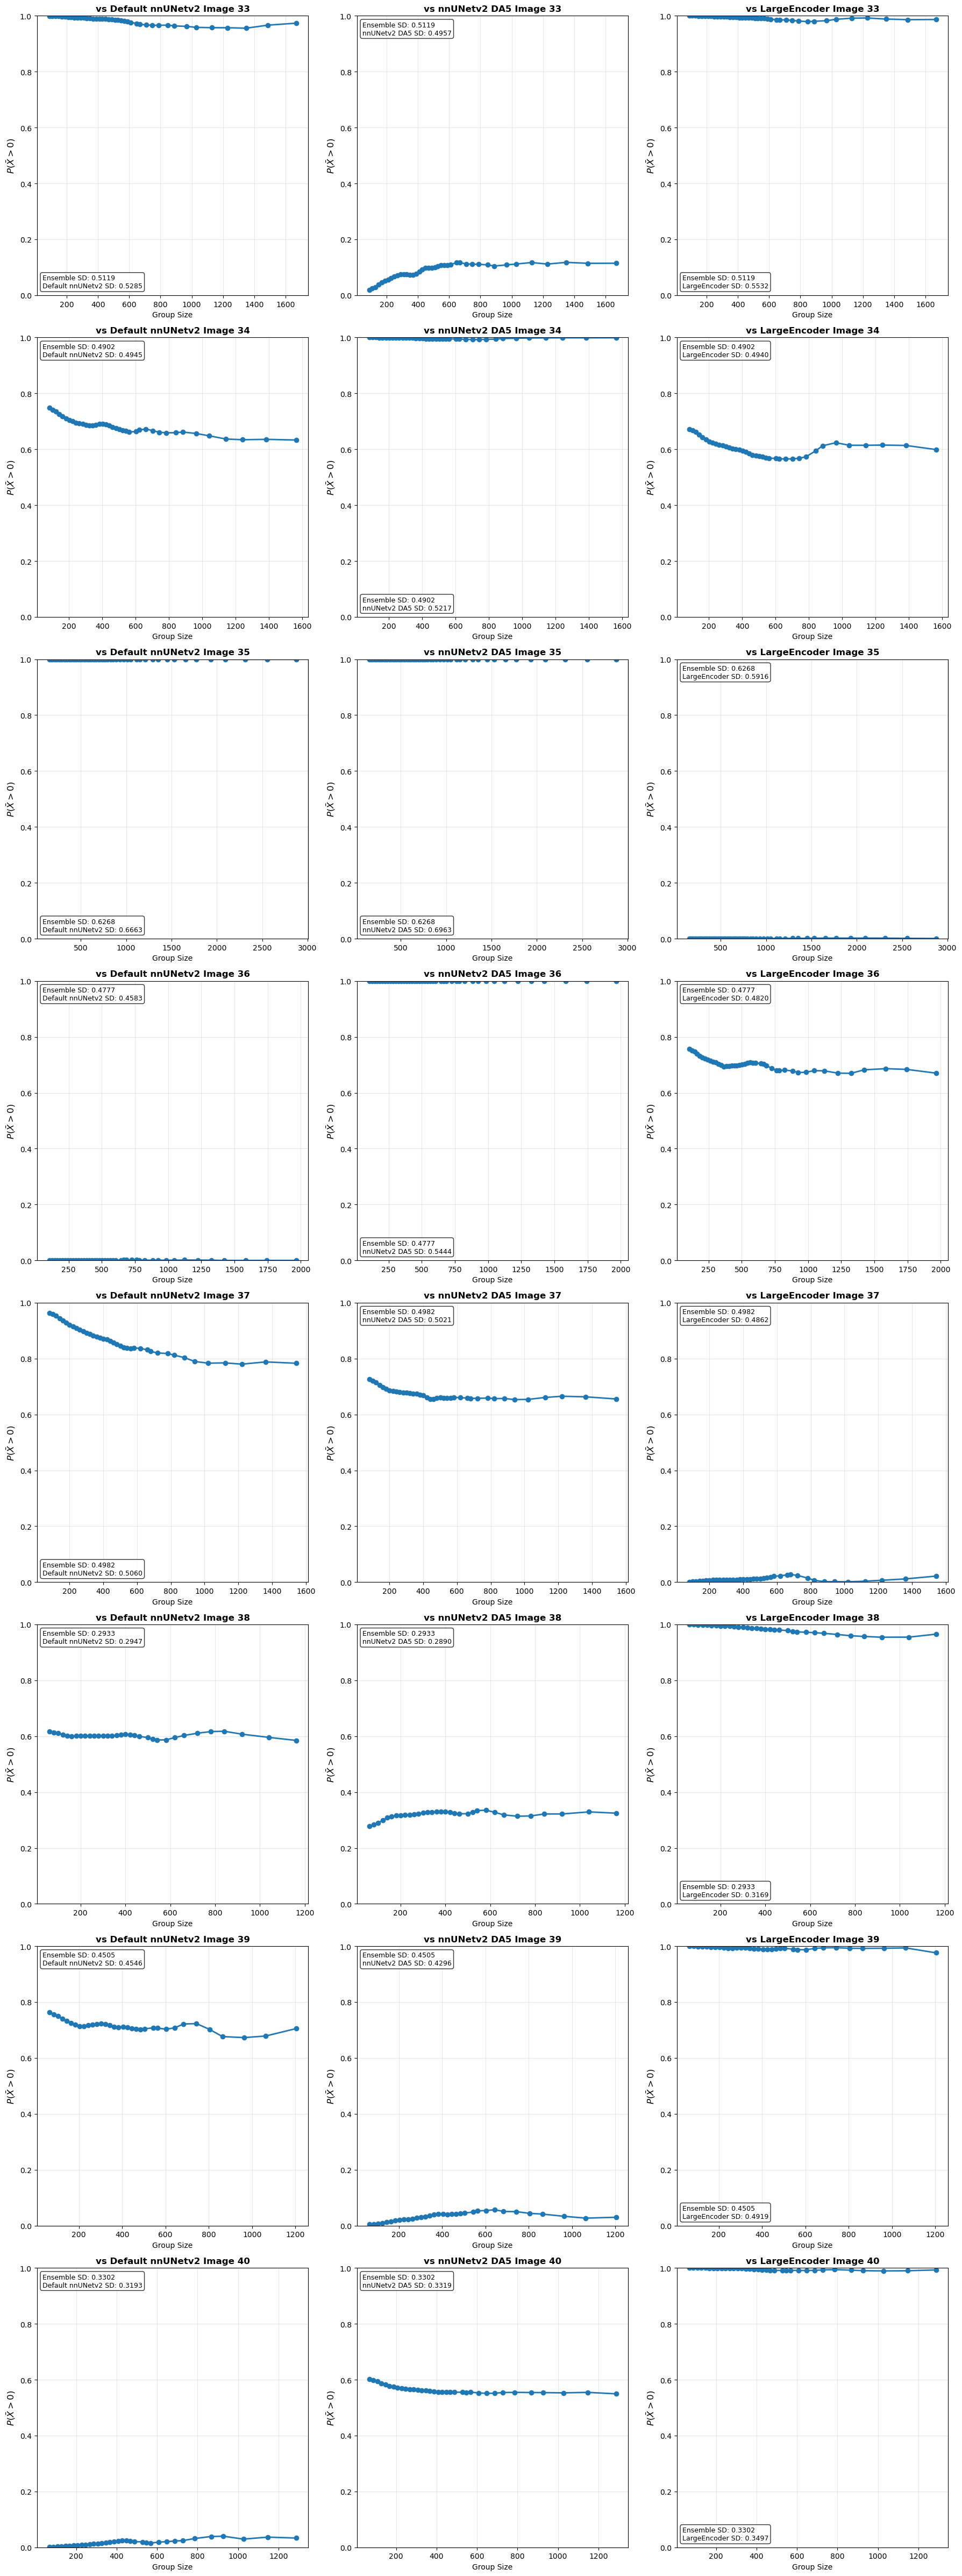


Comparison Summary (Ensemble vs Models):
Image 33 vs Default nnUNetv2:
  Ensemble Separation Distance: 0.5119 | Default nnUNetv2 Separation Distance: 0.5285


KeyError: 'significance'

In [54]:
import re
import numpy as np

def parse_performance_file(filename="performance_print.txt"):
    """Parse performance data directly from the text file."""
    performance_data = {}
    
    with open(filename, 'r') as f:
        content = f.read()
    
    # Find the pivot table section
    pivot_start = content.find("Pivot Table (Training Images vs Models):")
    if pivot_start == -1:
        print("Pivot table not found!")
        return {}
    
    # Extract the pivot table section
    pivot_section = content[pivot_start:]
    lines = pivot_section.split('\n')
    
    # Find the header line with model names
    header_line = None
    for i, line in enumerate(lines):
        if 'BasicPlans' in line and 'DA5_Segmentations' in line:
            header_line = line
            data_start_idx = i + 1
            break
    
    if header_line is None:
        print("Header line not found!")
        return {}
    
    # Parse model names from header
    header_clean = re.sub(r'Model\s+', '', header_line)
    models = re.split(r'\s{2,}', header_clean.strip())
    
    # Initialize performance_data structure
    for model in models:
        performance_data[model] = {}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        line = line.strip()
        if not line or not line[0].isdigit():
            continue
            
        parts = line.split()
        if len(parts) != len(models) + 1:
            continue
            
        image_num = parts[0]
        values = parts[1:]
        
        for model, value in zip(models, values):
            try:
                performance_data[model][image_num] = float(value)
            except ValueError:
                continue
    
    return performance_data

def parse_filename(filename):
    """Extract image number and model name from filename like '033BasicPlans'"""
    for i, char in enumerate(filename):
        if not char.isdigit():
            image_num = filename[:i]
            model_name = filename[i:]
            return image_num, model_name
    return None, None

def get_model_display_name(model_key):
    """Convert model key to display name."""
    model_map = {
        "BasicPlans": "Default nnUNetv2",
        "DA5_Segmentations": "nnUNetv2 DA5", 
        "largeencoder": "nnUNetv2 ResEncL"
    }
    return model_map.get(model_key, model_key)


# Parse the performance data
performance_data = parse_performance_file("performance_print.txt")

# Load pickle data
pickle_dir = "significance_pickles"
if os.path.exists(pickle_dir):
    all_files = os.listdir(pickle_dir)
    pickle_files = [f for f in all_files if f.endswith('.pkl')]
    pickle_files = [os.path.join(pickle_dir, f) for f in pickle_files]
else:
    pickle_files = []
    print("significance_pickles directory not found!")

all_data = {}
for file_path in pickle_files:
    filename = os.path.basename(file_path).replace('.pkl', '')
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_data[filename] = data
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

# Dictionary to store minimum p-values
p_vals = {}

# Create enhanced plotting with both ensemble and model separation distances
if all_data:
    # Sort data by image number first, then by model name
    sorted_items = []
    for filename, data in all_data.items():
        image_num, model_name = parse_filename(filename)
        if image_num and model_name:
            sorted_items.append((image_num, model_name, filename, data))
    
    # Sort by image number, then by model name
    sorted_items.sort(key=lambda x: (x[0], x[1]))
    
    n_files = len(sorted_items)
    cols = min(3, n_files)
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
    # Handle different subplot configurations
    if n_files == 1:
        axes = [axes]
    elif rows == 1 and cols > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each dataset in sorted order
    for i, (image_num, model_name, filename, data) in enumerate(sorted_items):
        if isinstance(data, dict) and data:
            x_vals = list(data.keys())
            y_vals = list(data.values())
            
            # Sort by x values
            sorted_pairs = sorted(zip(x_vals, y_vals))
            x_vals, y_vals = zip(*sorted_pairs)
            
            # Apply 3-term moving average
            y_vals_smoothed = moving_average(list(y_vals), window=3)
            
            # Find minimum point after smoothing for group_size > 600
            filtered_data = [(x, y) for x, y in zip(x_vals, y_vals_smoothed) if x > 600]
            
            if filtered_data:
                min_x, min_y = min(filtered_data, key=lambda x: x[1])
                # Store in p_vals dictionary
                p_vals[filename] = min_y
            else:
                # Fallback to overall minimum if no data > 600
                min_idx = np.argmin(y_vals_smoothed)
                min_x = x_vals[min_idx]
                min_y = y_vals_smoothed[min_idx]
                p_vals[filename] = min_y
            
            axes[i].plot(x_vals, y_vals_smoothed, 'o-', linewidth=2, markersize=6)
            axes[i].set_xlabel('Group Size')
            # Updated y-axis label with mathematical notation
            axes[i].set_ylabel(r'$P(\bar{X} > 0)$', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            
            # Fixed y-axis limits from 0 to 1
            axes[i].set_ylim(0, 1.0)
            
            # Get separation distances for both ensemble and model
            ensemble_sep = None
            model_sep = None
            if 'Ensemble' in performance_data:
                ensemble_sep = performance_data['Ensemble'].get(image_num)
            if model_name in performance_data:
                model_sep = performance_data[model_name].get(image_num)
            
            # Determine optimal text position based on data distribution
            # Check if upper region (0.8-1.0) has fewer data points than lower region (0.0-0.2)
            upper_points = sum(1 for y in y_vals_smoothed if y >= 0.8)
            lower_points = sum(1 for y in y_vals_smoothed if y <= 0.2)
            
            if upper_points <= lower_points:
                # Place in upper region
                text_x, text_y = 0.02, 0.98
                v_align = 'top'
            else:
                # Place in lower region
                text_x, text_y = 0.02, 0.02
                v_align = 'bottom'
            
            # Add separation distances as text on the plot
            text_lines = []
            if ensemble_sep is not None:
                text_lines.append(f"Ensemble SD: {ensemble_sep:.4f}")
            if model_sep is not None:
                model_display_name = get_model_display_name(model_name)
                text_lines.append(f"{model_display_name} SD: {model_sep:.4f}")
            
            if text_lines:
                text_content = '\n'.join(text_lines)
                axes[i].text(text_x, text_y, text_content, transform=axes[i].transAxes,
                           fontsize=9, verticalalignment=v_align, horizontalalignment='left',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Updated title format: vs {model} Image {image} (remove leading zeros)
            model_display_name = get_model_display_name(model_name)
            image_display = str(int(image_num))  # Convert to int to remove leading zeros, then back to string
            axes[i].set_title(f"vs {model_display_name} Image {image_display}", fontsize=12, fontweight='bold')
            
        else:
            axes[i].text(0.5, 0.5, f'No data\nin {filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{filename} (No Data)", fontsize=12)
    
    # Hide unused subplots
    for i in range(len(sorted_items), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary sorted by image->model with both separation distances
    print(f"\nComparison Summary (Ensemble vs Models):")
    print("=" * 90)
    
    # Collect and sort results by image, then model
    results = []
    for image_num, model_name, filename, data in sorted_items:
        if isinstance(data, dict) and data:
            min_p = p_vals[filename]  # Use the smoothed min value
            max_p = max(data.values())
            significant = "Yes" if max_p > 0.95 else "No"
            
            ensemble_sep = performance_data.get('Ensemble', {}).get(image_num)
            model_sep = performance_data.get(model_name, {}).get(image_num)
            
            results.append({
                'image': image_num,
                'model': model_name,
                'filename': filename,
                'min_p': min_p,
                'max_p': max_p,
                'significant': significant,
                'ensemble_sep': ensemble_sep,
                'model_sep': model_sep
            })
    
    # Print sorted results with improved formatting and display names (remove leading zeros)
    for result in results:
        ensemble_str = f"{result['ensemble_sep']:.4f}" if result['ensemble_sep'] is not None else "N/A"
        model_str = f"{result['model_sep']:.4f}" if result['model_sep'] is not None else "N/A"
        model_display_name = get_model_display_name(result['model'])
        image_display = str(int(result['image']))  # Remove leading zeros
        
        print(f"Image {image_display} vs {model_display_name}:")
        print(f"  Ensemble Separation Distance: {ensemble_str} | {model_display_name} Separation Distance: {model_str}")
        print(f"  Min p-value: {result['min_p']:.6f} | Max p-value: {result['max_p']:.6f} | Significant: {result['significance']}")
        print()

else:
    print("No data to plot")

# Print the p_vals dictionary
print("\nMinimum P-values Dictionary:")
print("=" * 40)
for filename, min_p in p_vals.items():
    print(f"'{filename}': {min_p:.6f}")

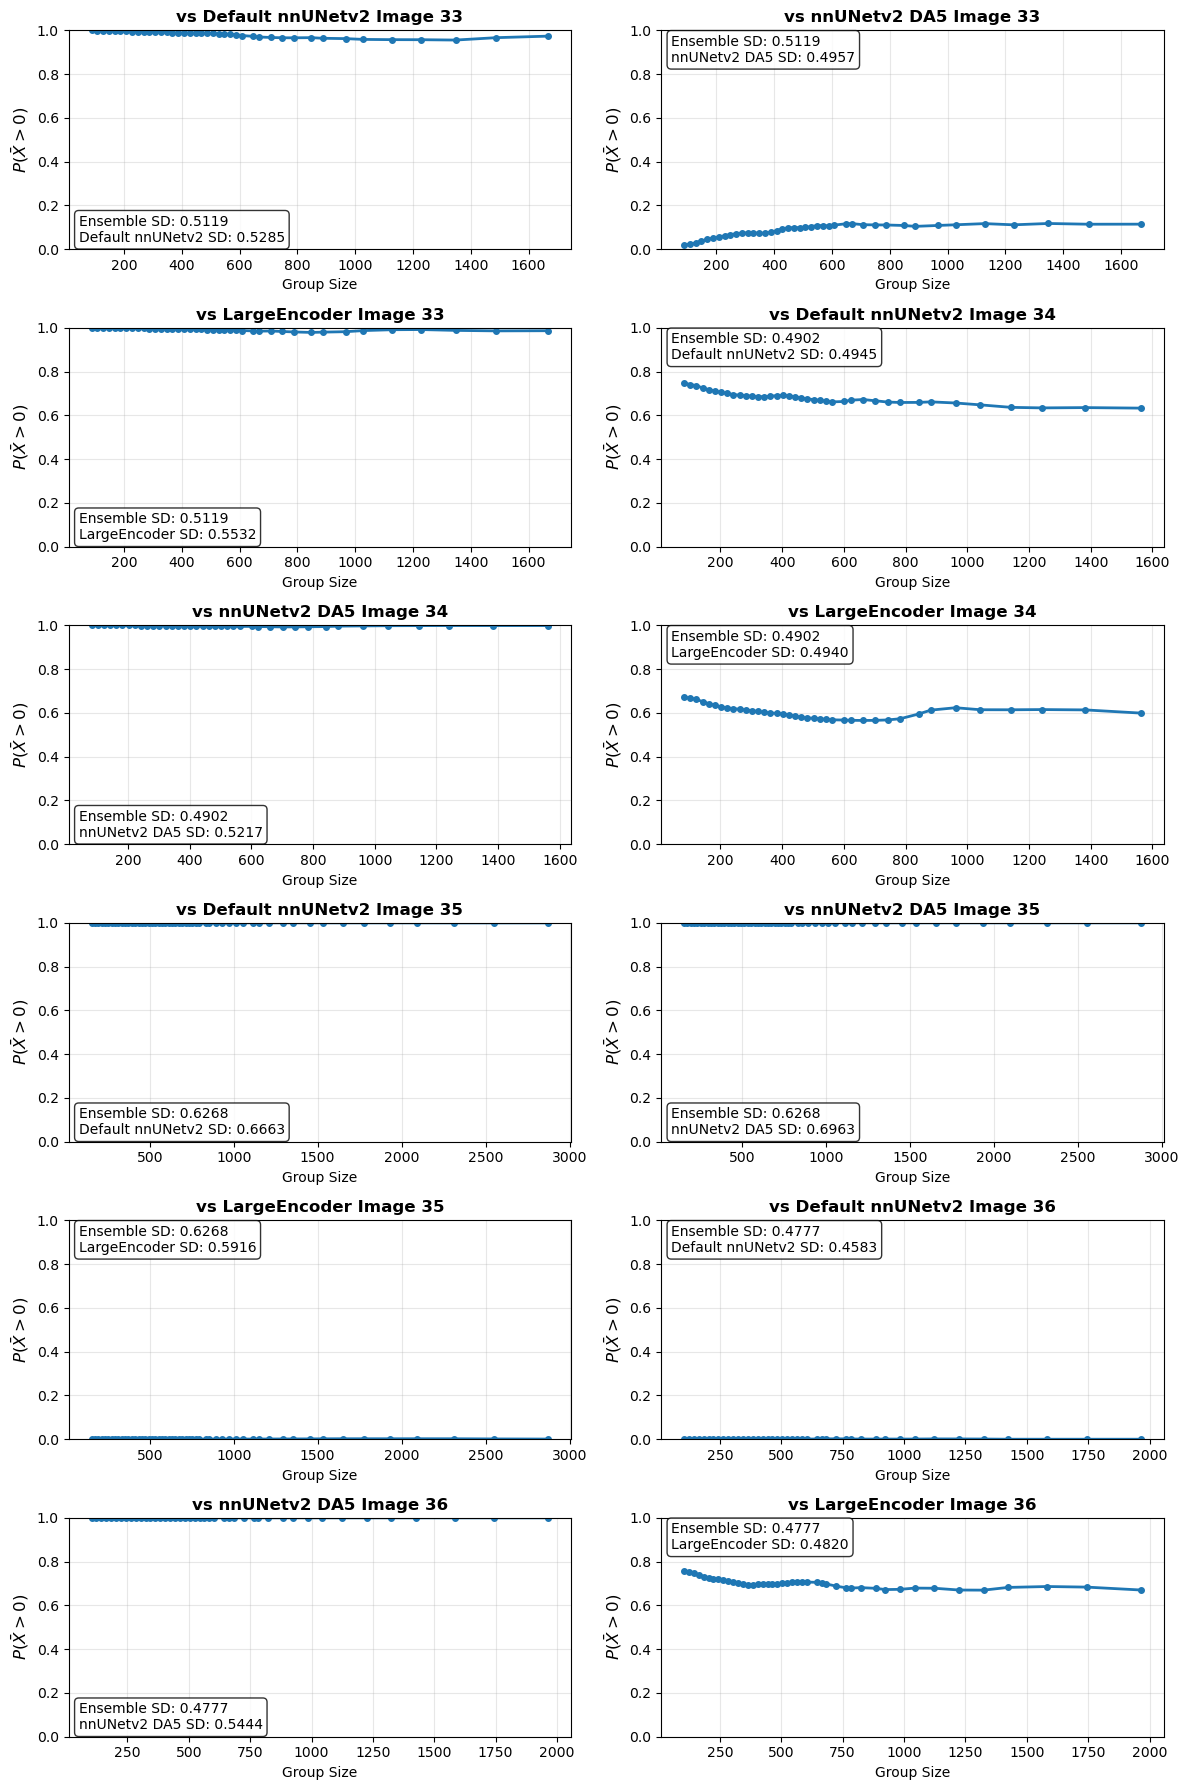


Comparison Summary for Images 33-36 (Ensemble vs Models):
Image 33 vs Default nnUNetv2:
  Ensemble SD: 0.5119 | Default nnUNetv2 SD: 0.5285
  Min p-value: 0.955591 | Max p-value: 0.999282 | Significant: Yes

Image 33 vs nnUNetv2 DA5:
  Ensemble SD: 0.5119 | nnUNetv2 DA5 SD: 0.4957
  Min p-value: 0.104433 | Max p-value: 0.126672 | Significant: No

Image 33 vs LargeEncoder:
  Ensemble SD: 0.5119 | LargeEncoder SD: 0.5532
  Min p-value: 0.979021 | Max p-value: 0.999902 | Significant: Yes

Image 34 vs Default nnUNetv2:
  Ensemble SD: 0.4902 | Default nnUNetv2 SD: 0.4945
  Min p-value: 0.633177 | Max p-value: 0.748188 | Significant: No

Image 34 vs nnUNetv2 DA5:
  Ensemble SD: 0.4902 | nnUNetv2 DA5 SD: 0.5217
  Min p-value: 0.992715 | Max p-value: 1.000000 | Significant: Yes

Image 34 vs LargeEncoder:
  Ensemble SD: 0.4902 | LargeEncoder SD: 0.4940
  Min p-value: 0.565471 | Max p-value: 0.672686 | Significant: No

Image 35 vs Default nnUNetv2:
  Ensemble SD: 0.6268 | Default nnUNetv2 SD: 0

In [8]:
import re
import numpy as np

def parse_performance_file(filename="performance_print.txt"):
    """Parse performance data directly from the text file."""
    performance_data = {}
    
    with open(filename, 'r') as f:
        content = f.read()
    
    # Find the pivot table section
    pivot_start = content.find("Pivot Table (Training Images vs Models):")
    if pivot_start == -1:
        print("Pivot table not found!")
        return {}
    
    # Extract the pivot table section
    pivot_section = content[pivot_start:]
    lines = pivot_section.split('\n')
    
    # Find the header line with model names
    header_line = None
    for i, line in enumerate(lines):
        if 'BasicPlans' in line and 'DA5_Segmentations' in line:
            header_line = line
            data_start_idx = i + 1
            break
    
    if header_line is None:
        print("Header line not found!")
        return {}
    
    # Parse model names from header
    header_clean = re.sub(r'Model\s+', '', header_line)
    models = re.split(r'\s{2,}', header_clean.strip())
    
    # Initialize performance_data structure
    for model in models:
        performance_data[model] = {}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        line = line.strip()
        if not line or not line[0].isdigit():
            continue
            
        parts = line.split()
        if len(parts) != len(models) + 1:
            continue
            
        image_num = parts[0]
        values = parts[1:]
        
        for model, value in zip(models, values):
            try:
                performance_data[model][image_num] = float(value)
            except ValueError:
                continue
    
    return performance_data

def parse_filename(filename):
    """Extract image number and model name from filename like '033BasicPlans'"""
    for i, char in enumerate(filename):
        if not char.isdigit():
            image_num = filename[:i]
            model_name = filename[i:]
            return image_num, model_name
    return None, None

def get_model_display_name(model_key):
    """Convert model key to display name."""
    model_map = {
        "BasicPlans": "Default nnUNetv2",
        "DA5_Segmentations": "nnUNetv2 DA5", 
        "largeencoder": "nnUNetv2 ResEncL"
    }
    return model_map.get(model_key, model_key)


# Parse the performance data
performance_data = parse_performance_file("performance_print.txt")

# Load pickle data
pickle_dir = "significance_pickles"
if os.path.exists(pickle_dir):
    all_files = os.listdir(pickle_dir)
    pickle_files = [f for f in all_files if f.endswith('.pkl')]
    pickle_files = [os.path.join(pickle_dir, f) for f in pickle_files]
else:
    pickle_files = []
    print("significance_pickles directory not found!")

all_data = {}
for file_path in pickle_files:
    filename = os.path.basename(file_path).replace('.pkl', '')
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_data[filename] = data
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

# Dictionary to store minimum p-values
p_vals = {}

# Filter for first 4 images (033, 034, 035, 036) and create enhanced plotting
if all_data:
    # Filter data for first 4 images only
    target_images = ['033', '034', '035', '036']
    filtered_items = []
    
    for filename, data in all_data.items():
        image_num, model_name = parse_filename(filename)
        if image_num and model_name and image_num in target_images:
            filtered_items.append((image_num, model_name, filename, data))
    
    # Sort by image number, then by model name
    filtered_items.sort(key=lambda x: (x[0], x[1]))
    
    n_files = len(filtered_items)
    
    # Fixed 6x2 grid (6 rows, 2 columns)
    rows = 6
    cols = 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 18))
    
    # Flatten axes for easier indexing
    axes = axes.flatten()
    
    # Plot each dataset in sorted order
    for i, (image_num, model_name, filename, data) in enumerate(filtered_items):
        if i >= 12:  # Only plot first 12 items (6x2 grid)
            break
            
        if isinstance(data, dict) and data:
            x_vals = list(data.keys())
            y_vals = list(data.values())
            
            # Sort by x values
            sorted_pairs = sorted(zip(x_vals, y_vals))
            x_vals, y_vals = zip(*sorted_pairs)
            
            # Apply 3-term moving average
            y_vals_smoothed = moving_average(list(y_vals), window=3)
            
            # Find minimum point after smoothing for group_size > 600
            filtered_data = [(x, y) for x, y in zip(x_vals, y_vals_smoothed) if x > 600]
            
            if filtered_data:
                min_x, min_y = min(filtered_data, key=lambda x: x[1])
                # Store in p_vals dictionary
                p_vals[filename] = min_y
            else:
                # Fallback to overall minimum if no data > 600
                min_idx = np.argmin(y_vals_smoothed)
                min_x = x_vals[min_idx]
                min_y = y_vals_smoothed[min_idx]
                p_vals[filename] = min_y
            
            axes[i].plot(x_vals, y_vals_smoothed, 'o-', linewidth=2, markersize=4)
            axes[i].set_xlabel('Group Size')
            # Updated y-axis label with mathematical notation
            axes[i].set_ylabel(r'$P(\bar{X} > 0)$', fontsize=12)
            axes[i].grid(True, alpha=0.3)
            
            # Fixed y-axis limits from 0 to 1
            axes[i].set_ylim(0, 1.0)
            
            # Get separation distances for both ensemble and model
            ensemble_sep = None
            model_sep = None
            if 'Ensemble' in performance_data:
                ensemble_sep = performance_data['Ensemble'].get(image_num)
            if model_name in performance_data:
                model_sep = performance_data[model_name].get(image_num)
            
            # Determine optimal text position based on data distribution
            # Check if upper region (0.8-1.0) has fewer data points than lower region (0.0-0.2)
            upper_points = sum(1 for y in y_vals_smoothed if y >= 0.8)
            lower_points = sum(1 for y in y_vals_smoothed if y <= 0.2)
            
            if upper_points <= lower_points:
                # Place in upper region
                text_x, text_y = 0.02, 0.98
                v_align = 'top'
            else:
                # Place in lower region
                text_x, text_y = 0.02, 0.02
                v_align = 'bottom'
            
            # Add separation distances as text on the plot
            text_lines = []
            if ensemble_sep is not None:
                text_lines.append(f"Ensemble SD: {ensemble_sep:.4f}")
            if model_sep is not None:
                model_display_name = get_model_display_name(model_name)
                text_lines.append(f"{model_display_name} SD: {model_sep:.4f}")
            
            if text_lines:
                text_content = '\n'.join(text_lines)
                axes[i].text(text_x, text_y, text_content, transform=axes[i].transAxes,
                           fontsize=10, verticalalignment=v_align, horizontalalignment='left',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Updated title format: vs {model} Image {image} (remove leading zeros)
            model_display_name = get_model_display_name(model_name)
            image_display = str(int(image_num))  # Convert to int to remove leading zeros, then back to string
            axes[i].set_title(f"vs {model_display_name} Image {image_display}", fontsize=12, fontweight='bold')
            
        else:
            axes[i].text(0.5, 0.5, f'No data\nin {filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f"{filename} (No Data)", fontsize=12)
    
    # Hide unused subplots
    for i in range(len(filtered_items), 12):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced summary for first 4 images
    print(f"\nComparison Summary for Images 33-36 (Ensemble vs Models):")
    print("=" * 90)
    
    # Collect and sort results by image, then model
    results = []
    for image_num, model_name, filename, data in filtered_items:
        if isinstance(data, dict) and data:
            min_p = p_vals.get(filename, 0)  # Use the smoothed min value
            max_p = max(data.values())
            significant = "Yes" if max_p > 0.95 else "No"
            
            ensemble_sep = performance_data.get('Ensemble', {}).get(image_num)
            model_sep = performance_data.get(model_name, {}).get(image_num)
            
            results.append({
                'image': image_num,
                'model': model_name,
                'filename': filename,
                'min_p': min_p,
                'max_p': max_p,
                'significant': significant,
                'ensemble_sep': ensemble_sep,
                'model_sep': model_sep
            })
    
    # Print sorted results
    for result in results:
        ensemble_str = f"{result['ensemble_sep']:.4f}" if result['ensemble_sep'] is not None else "N/A"
        model_str = f"{result['model_sep']:.4f}" if result['model_sep'] is not None else "N/A"
        model_display_name = get_model_display_name(result['model'])
        image_display = str(int(result['image']))  # Remove leading zeros
        
        print(f"Image {image_display} vs {model_display_name}:")
        print(f"  Ensemble SD: {ensemble_str} | {model_display_name} SD: {model_str}")
        print(f"  Min p-value: {result['min_p']:.6f} | Max p-value: {result['max_p']:.6f} | Significant: {result['significant']}")
        print()

else:
    print("No data to plot")

# Print the p_vals dictionary
print("\nMinimum P-values Dictionary:")
print("=" * 40)
for filename, min_p in p_vals.items():
    print(f"'{filename}': {min_p:.6f}")